In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,q11,q12,q22,Rc,psi0,A,R,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,1.099922,-0.193920,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,1.066764,-0.119714,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,1.016800,-0.154298,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,0.896874,-0.276325,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,0.847358,-0.169788,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.898473,0.197470,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.884289,0.308226,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.883521,0.168561,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.873263,0.225002,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,q11,q12,q22,Rc,psi0,A,R,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,1.099922,-0.193920,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,1.066764,-0.119714,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,1.016800,-0.154298,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,0.896874,-0.276325,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,0.847358,-0.169788,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.898473,0.197470,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.884289,0.308226,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.883521,0.168561,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.873263,0.225002,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


Calculate there vertical centers

In [4]:
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


In [5]:
# for e, eddy in enumerate(dic_eddies_vert.keys()):
#     dic = dic_eddies_vert[eddy]
#     df = compute_tilt_data(dic, int(eddy[4:]), num=6)
#     if e == 0:
#         df_tilt_data = df
#     else:
#         df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
# df_tilt_data.to_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl") 

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_tilt_data


,Eddy,Day,TiltDis,TiltDir
0,1,1465,31.669332,89.546110
1,1,1466,33.600109,92.955602
2,1,1467,35.159201,96.662951
3,1,1468,35.643445,101.070039
4,1,1469,34.916207,105.866105
...,...,...,...,...
89447,2631,10643,10.685422,350.104683
89448,2631,10644,10.055826,348.769338
89449,2631,10645,11.563679,343.688930
89450,2631,10646,12.848125,334.097803


In [6]:
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [7]:
num_profiles = len(df_eddies)-6*len(df_eddies.Eddy.unique())
print(f'Total No. of used profiles: {num_profiles}')
num_tilt_profiles = np.sum(~np.isnan(df_eddies.TiltDis))
print(f'Total No. of profiles tilt measured: {num_tilt_profiles}')
print(f'Tilt measuring success rate: {num_tilt_profiles/num_profiles}')


Total No. of used profiles: 89452
Total No. of profiles tilt measured: 74927
Tilt measuring success rate: 0.8376224120198542


In [8]:
df_tilt_data_clean = df_tilt_data.dropna().copy()
num_prof_TD_blw_40 = np.sum(df_tilt_data_clean.TiltDis <= 40) / num_tilt_profiles
print(f'No. Profiles below 40km TD: {num_prof_TD_blw_40}')
print(f'Max TD {df_tilt_data_clean.TiltDis.max()}')


No. Profiles below 40km TD: 0.8548053438680315
Max TD 152.19576956146645


In [9]:
df_eddy = df_eddies[df_eddies.Eddy==66]
df = df_eddy[(df_eddy.Day==(df_eddy.Day.iloc[0]+26))]
print(df.Eddy.values, df.TiltDis.values, df.TiltDir.values)

df_eddy = df_eddies[df_eddies.Eddy==425]
df = df_eddy[(df_eddy.Day==(df_eddy.Day.iloc[0]+17))]
print(df.Eddy.values, df.TiltDis.values, df.TiltDir.values)

df_eddy = df_eddies[df_eddies.Eddy==871]
df = df_eddy[(df_eddy.Day==(df_eddy.Day.iloc[0]+5))]
print(df.Eddy.values, df.TiltDis.values, df.TiltDir.values)

df_eddy = df_eddies[df_eddies.Eddy==1780]
df = df_eddy[(df_eddy.Day==(df_eddy.Day.iloc[0]+51))]
print(df.Eddy.values, df.TiltDis.values, df.TiltDir.values)

df_eddy = df_eddies[df_eddies.Eddy==31]
df = df_eddy[(df_eddy.Day==(df_eddy.Day.iloc[0]+68))]
print(df.Eddy.values, df.TiltDis.values, df.TiltDir.values)

df_eddy = df_eddies[df_eddies.Eddy==182]
df = df_eddy[(df_eddy.Day==(df_eddy.Day.iloc[0]+89))]
print(df.Eddy.values, df.TiltDis.values, df.TiltDir.values)

df_eddy = df_eddies[df_eddies.Eddy==1602]
df = df_eddy[(df_eddy.Day==(df_eddy.Day.iloc[0]+114))]
print(df.Eddy.values, df.TiltDis.values, df.TiltDir.values)

df_eddy = df_eddies[df_eddies.Eddy==2128]
df = df_eddy[(df_eddy.Day==(df_eddy.Day.iloc[0]+40))]
print(df.Eddy.values, df.TiltDis.values, df.TiltDir.values)


[66] [28.79620306] [340.26031108]
[425] [5.54364912] [359.98190951]
[871] [12.76771387] [328.62092311]
[1780] [19.47665894] [36.31906537]
[31] [nan] [nan]
[182] [18.52790927] [132.39056429]
[1602] [6.38254966] [160.93079805]
[2128] [10.4914819] [244.6769082]


#### Additional Data

In [53]:
def coriolis(lat_deg):
    Omega = 7.2921e-5  # Earth's rotation rate [rad/s]
    return 2 * Omega * np.sin(np.deg2rad(lat_deg))
df_eddies['f'] = coriolis(df_eddies.Lat)

day_idxs = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    if len(df):
        day_idxs.extend(df.Day-df.Day.iloc[0])
df_eddies['Day_idx'] = day_idxs

norm_time = []
for eddy in df_eddies.Eddy.unique():
    seg = df_eddies[df_eddies.Eddy == eddy]
    n = len(seg)
    norm_time.extend(np.arange(n) / n)
df_eddies['norm_time'] = norm_time

eddy_props = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    eddy_props.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) * 0.011574))
df_eddies['EddyProp'] = eddy_props

# displacement of top center
dxs, dys = [], []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    dxs.extend(df.xc.diff())
    dys.extend(df.yc.diff())
df_eddies['dx_top'] = dxs
df_eddies['dy_top'] = dys

# bottom of eddy propogation
df_idx = df_eddies.set_index(['Eddy', 'Day'])
eddy_btm_prop = []
for eddy, dic in dic_eddies_vert.items():
    x_btms, y_btms = [], []
    eddy_id = int(eddy[4:])
    for day, df in dic.items():
        if len(df):
            data = df.iloc[-1]
            xc, yc = data.x, data.y
        else:
            day_id = int(day[3:])
            data = df_idx.loc[(eddy_id, day_id)]
            xc, yc = data.xc, data.yc
        x_btms.append(xc)
        y_btms.append(yc)
    disp = np.hypot(np.diff(x_btms), np.diff(y_btms)) * 0.011574
    disp = np.insert(disp, 0, np.nan)   # add NaN at the start
    eddy_btm_prop.extend(disp)
df_eddies['btm_prop'] = eddy_btm_prop

# displacement of bottom center
df_idx = df_eddies.set_index(['Eddy', 'Day'])
dxs, dys = [], []
for eddy, dic in dic_eddies_vert.items():
    x_btms, y_btms = [], []
    eddy_id = int(eddy[4:])
    for day, df in dic.items():
        if len(df):
            data = df.iloc[-1]
            xc, yc = data.x, data.y
        else:
            day_id = int(day[3:])
            data = df_idx.loc[(eddy_id, day_id)]
            xc, yc = data.xc, data.yc
        x_btms.append(xc)
        y_btms.append(yc)
    dx = np.diff(x_btms)
    dy = np.diff(y_btms)
    dx = np.insert(dx, 0, np.nan)  
    dy = np.insert(dy, 0, np.nan) 
    dxs.extend(dx)
    dys.extend(dy)
df_eddies['dx_btm'] = dxs
df_eddies['dy_btm'] = dys

# vector difference between top and bottom m/s
df_eddies['top_btm_diff'] = np.hypot(df_eddies.dx_btm - df_eddies.dx_top,
                                     df_eddies.dy_btm - df_eddies.dy_top)  * 0.011574

ARs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
df_eddies['AR'] = ARs

hs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    hs.append(h[data.ic, data.jc])
df_eddies['h'] = hs

# # bathy of bottom center at 1k depth 
# from scipy.spatial import cKDTree
# # build KD-tree once for the grid
# xy_grid = np.c_[X_grid.ravel(), Y_grid.ravel()]
# tree = cKDTree(xy_grid)
# df_idx = df_eddies.set_index(['Eddy', 'Day'])
# h_btms = []
# for eddy, dic in dic_eddies_vert.items():
#     eddy_id = int(eddy[4:])
#     for day, df in dic.items():
#         if not df.empty:
#             df = df.copy()
#             df = df[df.Depth.abs() < 1000]
#             data = df.iloc[-1]
#             xc, yc = data.x, data.y
#         else:
#             day_id = int(day[3:])
#             data = df_idx.loc[(eddy_id, day_id)]
#             xc, yc = data.xc, data.yc
#         _, k = tree.query((xc, yc))
#         i, j = divmod(k, X_grid.shape[1])
#         h_btms.append(h[i, j])
# df_eddies['h_btm'] = h_btms

fs = []
f = np.transpose(dataset.variables['f'], axes=(1, 0))
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    fs.append(f[data.ic, data.jc])
df_eddies['f'] = fs

df_eddies['Ro'] = np.abs(df_eddies.w / df_eddies.f)

def slope_mag(h, X, Y, mask=None, slope_type='mag'):
    # derivatives wrt index space (i, j)
    x_i, x_j = np.gradient(X)
    y_i, y_j = np.gradient(Y)
    h_i, h_j = np.gradient(h)
    # Jacobian and physical-space gradients
    J = x_i*y_j - x_j*y_i
    dhdx = ( h_i*y_j - h_j*y_i) / J
    dhdy = (-h_i*x_j + h_j*x_i) / J
    if slope_type == 'x':
        return dhdx
    if slope_type == 'y':
        return dhdy
    S = np.hypot(dhdx, dhdy)          # slope magnitude = tan(theta)
    S[np.isclose(J, 0)] = np.nan       # guard against singular cells
    if mask is not None:               # mask: 1=ocean, 0=land
        S = np.where(mask.astype(bool), S, np.nan)
    return S
s = slope_mag(h/1e3, X_grid, Y_grid, mask=mask_rho)
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

# s_x = slope_mag(h/1e3, X_grid, Y_grid, mask=mask_rho, slope_type='x')
# df_eddies['s_x'] = s_x[df_eddies.ic, df_eddies.jc]

# s_y = slope_mag(h/1e3, X_grid, Y_grid, mask=mask_rho, slope_type='y')
# df_eddies['s_y'] = s_y[df_eddies.ic, df_eddies.jc]

# Burger Number
H = 300
# L = 50000
L = df_eddies.Rc.median()*1e3
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_300m_ave.npy')
f = np.transpose(dataset.variables['f'], axes=(1, 0))
Bu = ( (Nbar_ave * H) / (f * L) )**2
Bu = np.where(mask_rho, Bu, np.nan)
Bu = np.where(h > H, Bu, np.nan)
Bus = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    Bus.append(Bu[data.ic, data.jc])
df_eddies['Bu'] = Bus

# H = 300
# Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_300m_ave.npy')
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
# for k in range(len(df_eddies)):
#     data = df_eddies.iloc[k]
#     Bu = ( (Nbar_ave[data.ic, data.jc] * H) / (f[data.ic, data.jc] * data.Rc) )**2
#     Bus.append(Bu)
# df_eddies['Bu'] = Bus

df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

df_AE_ = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE_ = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()

print(f'AE TD Mean: {round(df_AE.TiltDis.mean())}km')
print(f'CE TD Mean: {round(df_CE.TiltDis.mean())}km')


AE TD Mean: 24km
CE TD Mean: 21km


### Latitude Analysis

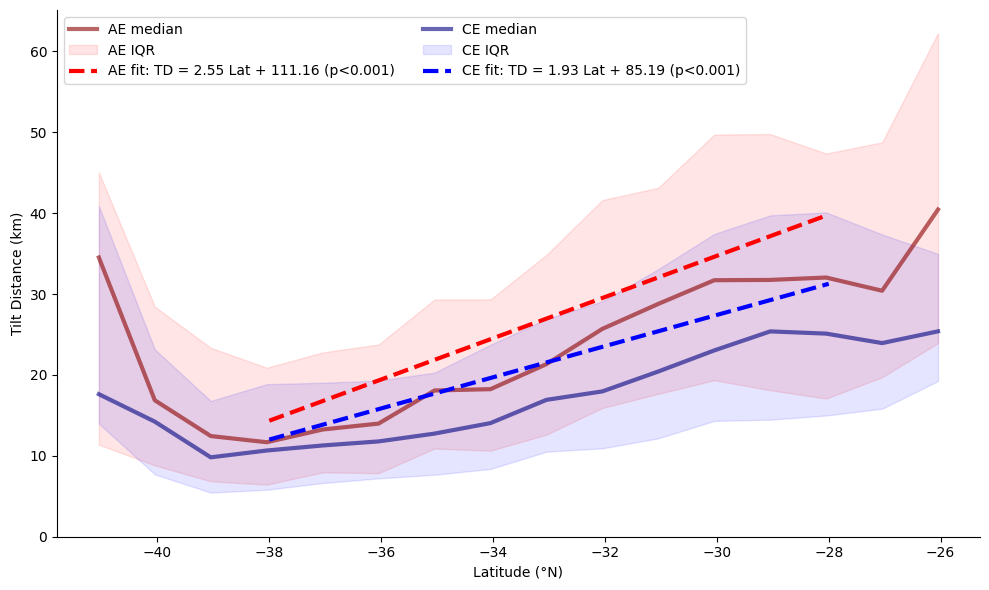

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

bins = np.arange(lat_rho.min(), lat_rho.max(), 1)

for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].dropna()

    tilt = df_masked['TiltDis']
    lat  = df_masked['Lat']

    bin_centers = .5 * (bins[:-1] + bins[1:])
    digitized = np.digitize(lat, bins)

    median = [tilt[digitized == i].median()        for i in range(1, len(bins))]
    q25    = [tilt[digitized == i].quantile(0.25)  for i in range(1, len(bins))]
    q75    = [tilt[digitized == i].quantile(0.75)  for i in range(1, len(bins))]

    # median + IQR (all data)
    ax.plot(bin_centers, median, color=styles[cyc]['line'], lw=3, label=f'{cyc} median', alpha=.6)
    ax.fill_between(
        bin_centers,
        q25, q75,
        color=styles[cyc]['fill'],
        alpha=0.1,
        label=f'{cyc} IQR'
    )

    # ---- regression ONLY from min(lat) to -38° ----
    reg_mask = (lat <= -28) & (lat >= -38)
    # reg_mask = (lat <= lat.max()) & (lat >= -38)
    lat_reg  = lat[reg_mask]
    tilt_reg = tilt[reg_mask]

    if len(lat_reg) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(lat_reg.values, tilt_reg.values)

        lat_line  = np.linspace(lat_reg.min(), lat_reg.max(), 100)
        tilt_line = slope * lat_line + intercept

        m, c = slope, intercept
        if c >= 0:
            eq_str = f'TD = {m:.2f} Lat + {c:.2f}'
        else:
            eq_str = f'TD = {m:.2f} Lat - {abs(c):.2f}'

        p_str = 'p<0.001' if p_value < 0.001 else f'p = {p_value:.3f}'

        ax.plot(
            lat_line,
            tilt_line,
            lw=3,
            color=styles[cyc]['fill'],
            linestyle='--',
            label=f'{cyc} fit: {eq_str} ({p_str})'
        )

ax.set_ylim(0, None)
ax.set_xlabel(r'Latitude (°N)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)
# ax.grid(True)
plt.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


2.9187645906182667 80.6132795519723
2.4408973993907153 103.98748080346913


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


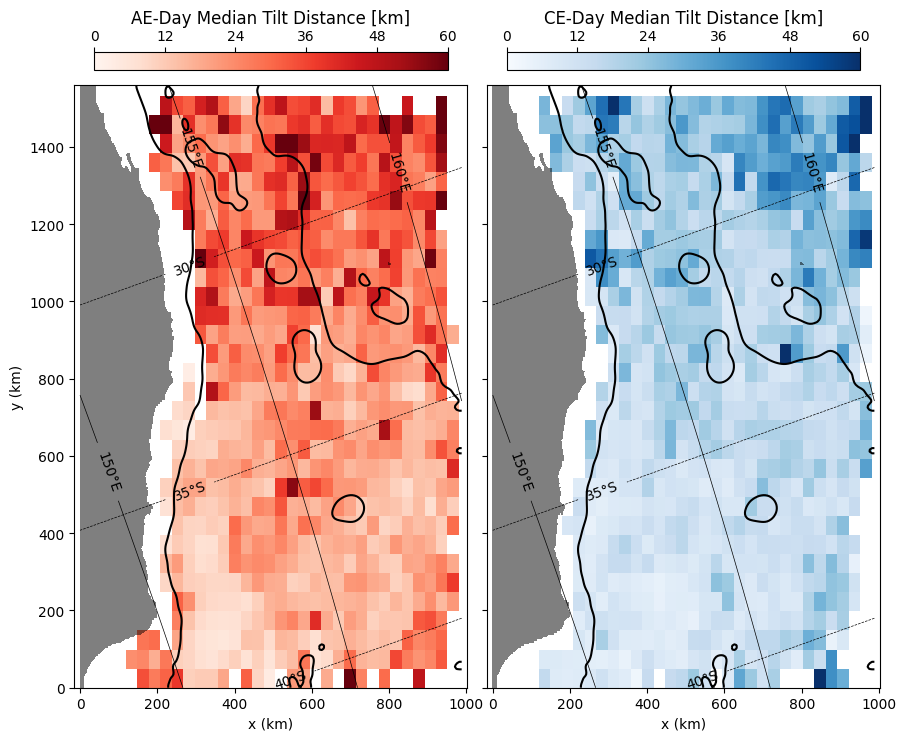

Unique Δx: [29.73256356]
Unique Δy: [49.42377476]
Number of x-bins: 30
Number of y-bins: 31
Min/max tilt per bin:
2.4408973993907153 103.98748080346913


In [12]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: 
            return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])

    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)

    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))

    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))

    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)

    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 60
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"AE-Day": "Reds", "CE-Day": "Blues"}

def binned_median(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & np.isfinite(v)

    ix, iy, v = ix[ok], iy[ok], v[ok]
    flat = iy * nx + ix

    hmed = np.full(nx * ny, np.nan)
    for k in np.unique(flat):
        hmed[k] = np.nanmedian(v[flat == k])

    return hmed.reshape(ny, nx)

fig, axs = plt.subplots(1, 2, figsize=(9, 8), sharey=True)

for ax, cyc in zip(axs, ['AE-Day', 'CE-Day']):
    df = df_eddies[df_eddies.Cyc == cyc[:2]].copy()
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_median(df.xc.values, df.yc.values, df.TiltDis.values, xbins, ybins)
    print(np.nanmin(H), np.nanmax(H))
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm,
                      shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Median Tilt Distance [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()

dx = np.diff(xbins)
dy = np.diff(ybins)

print("Unique Δx:", np.unique(dx))
print("Unique Δy:", np.unique(dy))
print("Number of x-bins:", len(dx))
print("Number of y-bins:", len(dy))

print("Min/max tilt per bin:")
print(np.nanmin(H), np.nanmax(H))  


/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1619: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


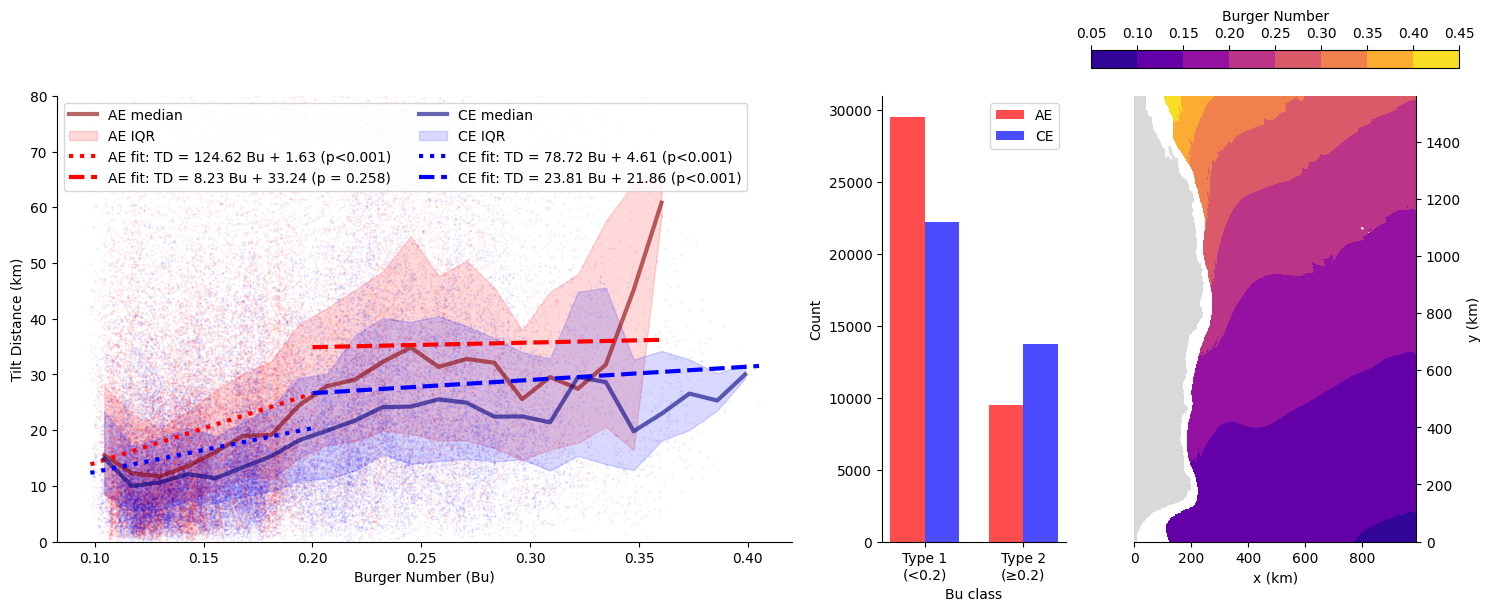

In [13]:
from scipy.stats import linregress

fig, (ax, ax_hist, ax2) = plt.subplots(
    1, 3, figsize=(15, 6),
    gridspec_kw={'width_ratios': [2, .5, 1]},
    constrained_layout=True
)

styles = {'AE': {'line': 'darkred', 'fill': 'red'},
          'CE': {'line': 'navy',    'fill': 'blue'}}

# split = 0.45
split = 0.2

# ------------------------------------------------------------
# LEFT PANEL – TILT vs BU (median, IQR, split regression)
# ------------------------------------------------------------
df_all = df_eddies.dropna(subset=['Bu', 'TiltDis'])

bu_vals = df_all.Bu.values
bins = np.linspace(bu_vals.min(), bu_vals.max(), 25)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

Bu_AE, Bu_CE = [], []

for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].dropna(subset=['Bu', 'TiltDis']).copy()

    bu   = df_masked['Bu'].values
    tilt = df_masked['TiltDis'].values

    if cyc == 'AE':
        Bu_AE.append(bu)
    else:
        Bu_CE.append(bu)

    digitized = np.digitize(bu, bins)
    median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    median = np.array(median)
    q25    = np.array(q25)
    q75    = np.array(q75)
    mask = np.isfinite(median)

    ax.plot(bin_centers[mask], median[mask], color=styles[cyc]['line'],
            lw=3, alpha=.6, label=f'{cyc} median')
    ax.fill_between(bin_centers[mask], q25[mask], q75[mask],
                    color=styles[cyc]['fill'], alpha=.15, label=f'{cyc} IQR')

    ax.scatter(bu, tilt, s=1, alpha=0.08, marker='.',
               color=styles[cyc]['fill'])    

    # Split regression
    mask_left  = bu < split
    mask_right = bu >= split

    if mask_left.sum() > 2:
        m1, c1, r1, p1, se1 = linregress(bu[mask_left], tilt[mask_left])
        x1 = np.linspace(bu[mask_left].min(), bu[mask_left].max(), 100)
        y1 = m1 * x1 + c1
        eq_str = f'TD = {m1:.2f} Bu + {c1:.2f}' if c1 >= 0 else f'TD = {m1:.2f} Bu - {abs(c1):.2f}'
        p_str  = 'p<0.001' if p1 < 0.001 else f'p = {p1:.3f}'
        ax.plot(x1, y1, ':', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc} fit: {eq_str} ({p_str})')
    
    if mask_right.sum() > 2:
        m2, c2, r2, p2, se2 = linregress(bu[mask_right], tilt[mask_right])
        x2 = np.linspace(bu[mask_right].min(), bu[mask_right].max(), 100)
        y2 = m2 * x2 + c2
        eq_str = f'TD = {m2:.2f} Bu + {c2:.2f}' if c2 >= 0 else f'TD = {m2:.2f} Bu - {abs(c2):.2f}'
        p_str  = 'p<0.001' if p2 < 0.001 else f'p = {p2:.3f}'
        ax.plot(x2, y2, '--', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc} fit: {eq_str} ({p_str})')
# ax.text(.3, 25, f'Type 1\n(<{split:.2f})')
# ax.text(.7, 45, f'Type 2\n(≥{split:.2f})')

ax.set_xlabel('Burger Number (Bu)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)
ax.set_ylim(0, 80)

# ------------------------------------------------------------
# MIDDLE PANEL – TYPE 1 / TYPE 2 HISTOGRAM
# ------------------------------------------------------------
Bu_AE = np.concatenate(Bu_AE) if Bu_AE else np.array([])
Bu_CE = np.concatenate(Bu_CE) if Bu_CE else np.array([])

type1_AE = np.sum(Bu_AE < split)
type2_AE = np.sum(Bu_AE >= split)
type1_CE = np.sum(Bu_CE < split)
type2_CE = np.sum(Bu_CE >= split)

x = np.arange(2)
w = 0.35

ax_hist.bar(x - w/2, [type1_AE, type2_AE], width=w,
            color=styles['AE']['fill'], alpha=0.7, label='AE')
ax_hist.bar(x + w/2, [type1_CE, type2_CE], width=w,
            color=styles['CE']['fill'], alpha=0.7, label='CE')

ax_hist.set_xticks(x)
ax_hist.set_xticklabels([f'Type 1\n(<{split})', f'Type 2\n(≥{split})'])
ax_hist.set_ylabel('Count')
ax_hist.set_xlabel('Bu class')
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.legend(loc='upper right')

# ------------------------------------------------------------------
# RIGHT PANEL: MAP 
# ------------------------------------------------------------------
cf = ax2.contourf(X_grid, Y_grid, Bu, cmap='plasma')
ax2.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
cbar = fig.colorbar(cf, ax=ax2, location='top')
cbar.set_label('Burger Number')
# ax2.contour(X_grid, Y_grid, Bu, levels=[split], colors=['w'])
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()


Need to explore further and get correct burger number


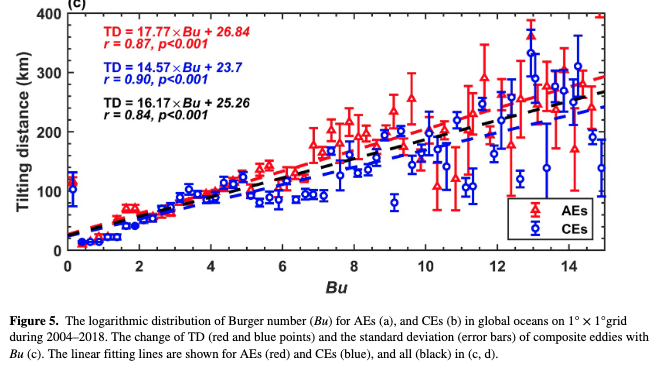





### Time Analysis

In [14]:
age_stops = list(np.arange(0, 151, 10)) + [500]

rows = []

for cyc_label, df_data in zip(['AE', 'CE'], [df_AE, df_CE]):
    for i, age1 in enumerate(age_stops):
        for age2 in age_stops[i+1:]:

            # enforce minimum width of 50 days
            if age2 - age1 < 50:
                continue

            sub = df_data[
                (df_data.Age >= age1) &
                (df_data.Age < age2)
            ][['Age', 'TiltDis', 'norm_time']].dropna()

            if len(sub) < 2:
                continue

            slope, intercept, r, p, err = linregress(
                sub.norm_time.values,
                sub.TiltDis.values
            )

            rows.append({
                'Cyc': cyc_label,
                'age1': age1,
                'age2': age2,
                'slope': slope,
                'intercept': intercept,
                'R2': r**2,
                'p': p,
                'err': err
            })

df_tilt_age_ints = pd.DataFrame(rows)
df_tilt_age_ints = df_tilt_age_ints[df_tilt_age_ints.age1 <= 100]
df_tilt_age_ints


,Cyc,age1,age2,slope,intercept,R2,p,err
0,AE,0,50,0.881654,26.844580,0.000095,0.181485,0.659800
1,AE,0,60,1.688614,25.749220,0.000372,0.003668,0.581137
2,AE,0,70,1.768672,25.368390,0.000424,0.001084,0.541171
3,AE,0,80,1.674179,25.316880,0.000393,0.000964,0.507144
4,AE,0,90,1.695614,24.988308,0.000412,0.000456,0.483699
...,...,...,...,...,...,...,...,...
154,CE,90,140,0.487884,18.517008,0.000067,0.637909,1.036577
155,CE,90,150,0.135893,18.393754,0.000005,0.892042,1.001189
156,CE,90,500,-0.282146,17.376980,0.000026,0.734405,0.831569
157,CE,100,150,2.169013,17.077454,0.001649,0.073972,1.213263


In [15]:
# Find max and min slopes
df_tilt_age_ints_AE = df_tilt_age_ints[df_tilt_age_ints.Cyc=='AE'].copy()
max_AE_slope = df_tilt_age_ints_AE.iloc[df_tilt_age_ints_AE.slope.abs().argmax()]
min_AE_slope = df_tilt_age_ints_AE.iloc[df_tilt_age_ints_AE.slope.abs().argmin()]

df_tilt_age_ints_CE = df_tilt_age_ints[df_tilt_age_ints.Cyc=='CE'].copy()
max_CE_slope = df_tilt_age_ints_CE.iloc[df_tilt_age_ints_CE.slope.abs().argmax()]
min_CE_slope = df_tilt_age_ints_CE.iloc[df_tilt_age_ints_CE.slope.abs().argmin()]


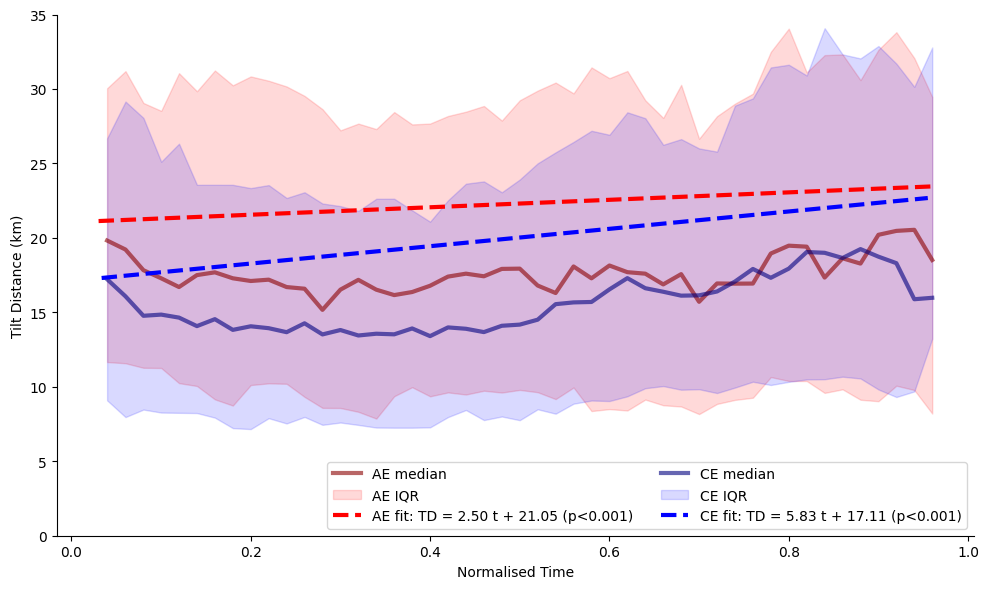

In [16]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

bin_width = 0.02  # adjust if you want finer/coarser bins

fig, ax = plt.subplots(figsize=(10, 6))

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

# ------------------------------------------------------------
# 1) Build selected dataframes for AE / CE (once)
# ------------------------------------------------------------
df_sel = {}

for cyc, df_data in zip(['AE', 'CE'], [df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] == 'AE':
            if (seg.Age.iloc[0] >= max_AE_slope.age1) & (seg.Age.iloc[0] <= max_AE_slope.age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis}))
        else:
            if (seg.Age.iloc[0] >= max_CE_slope.age1) & (seg.Age.iloc[0] <= max_CE_slope.age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis}))

    if df_list:
        df_sel[cyc] = pd.concat(df_list, ignore_index=True).dropna()
    else:
        df_sel[cyc] = pd.DataFrame(columns=['x', 'y'])

# ------------------------------------------------------------
# 2) Define common bins in normalised time
# ------------------------------------------------------------
x_all = np.concatenate([df_sel['AE'].x.values, df_sel['CE'].x.values])
bins = np.arange(x_all.min(), x_all.max() + bin_width, bin_width)

# ------------------------------------------------------------
# 3) Plot median + IQR and single regression for each type
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:
    df = df_sel[cyc].copy()
    if df.empty:
        continue

    x = df.x.values
    y = df.y.values

    # binned median + IQR (shared bins)
    df['bin'] = pd.cut(df.x, bins=bins, include_lowest=True)
    grp = df.groupby('bin', observed=False)['y']

    med = grp.median()
    q25 = grp.quantile(0.25)
    q75 = grp.quantile(0.75)

    bin_centers = np.array([interval.mid for interval in med.index])
    mask = med.notna()

    ax.plot(
        bin_centers[mask],
        med.values[mask],
        lw=3,
        color=styles[cyc]['line'],
        alpha=0.6,
        label=f'{cyc} median'
    )

    ax.fill_between(
        bin_centers[mask],
        q25.values[mask],
        q75.values[mask],
        color=styles[cyc]['fill'],
        alpha=0.15,
        label=f'{cyc} IQR'
    )

    # regression over full range (no split)
    slope, intercept, r, p, err = linregress(x, y)

    x_line = np.linspace(x.min(), x.max(), 200)
    y_line = slope * x_line + intercept

    if intercept >= 0:
        eq_str = f'TD = {slope:.2f} t + {intercept:.2f}'
    else:
        eq_str = f'TD = {slope:.2f} t - {abs(intercept):.2f}'

    p_str = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'

    ax.plot(
        x_line, y_line,
        color=styles[cyc]['fill'],
        linestyle='--',
        lw=3,
        label=f'{cyc} fit: {eq_str} ({p_str})'
    )

ax.set_ylim(0, 35)
ax.set_xlabel('Normalised Time')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='lower right', ncol=2)

plt.tight_layout()
plt.show()







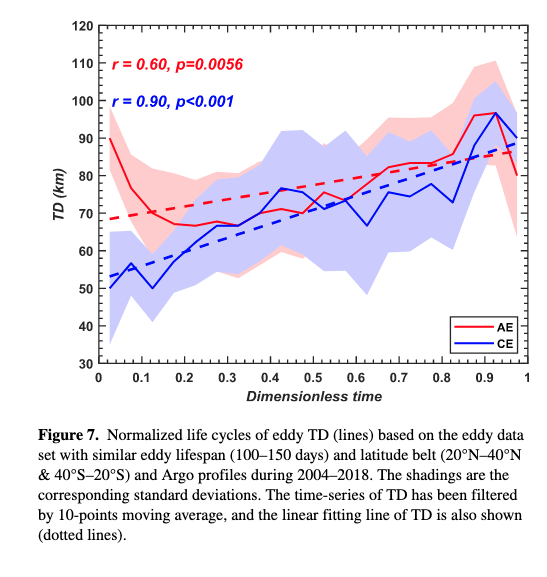

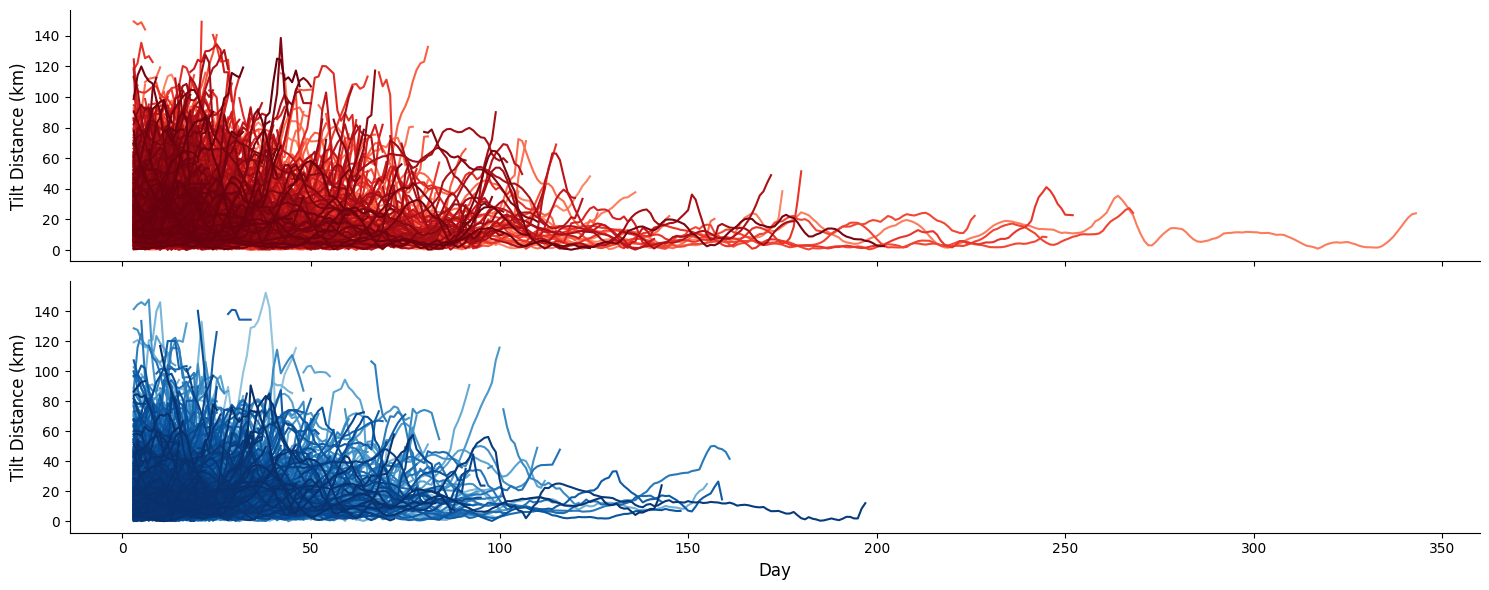

In [17]:
import matplotlib.cm as cm

ae = df_eddies[df_eddies.Cyc == 'AE'].Eddy.unique()
ce = df_eddies[df_eddies.Cyc == 'CE'].Eddy.unique()
# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ae_idx, ce_idx = 0, 0
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        axs[0].plot(np.arange(len(df)), df.TiltDis, color=colors_ae[ae_idx])
        # axs[0].set_xlabel('Day', fontsize=12)
        axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        ae_idx += 1
    else:
        axs[1].plot(np.arange(len(df)), df.TiltDis, color=colors_ce[ce_idx])
        axs[1].set_xlabel('Day', fontsize=12)
        axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        ce_idx += 1
plt.tight_layout()

In [18]:
df_eddies.Rc.median()

np.float64(77.52197534407037)

### Seasonality



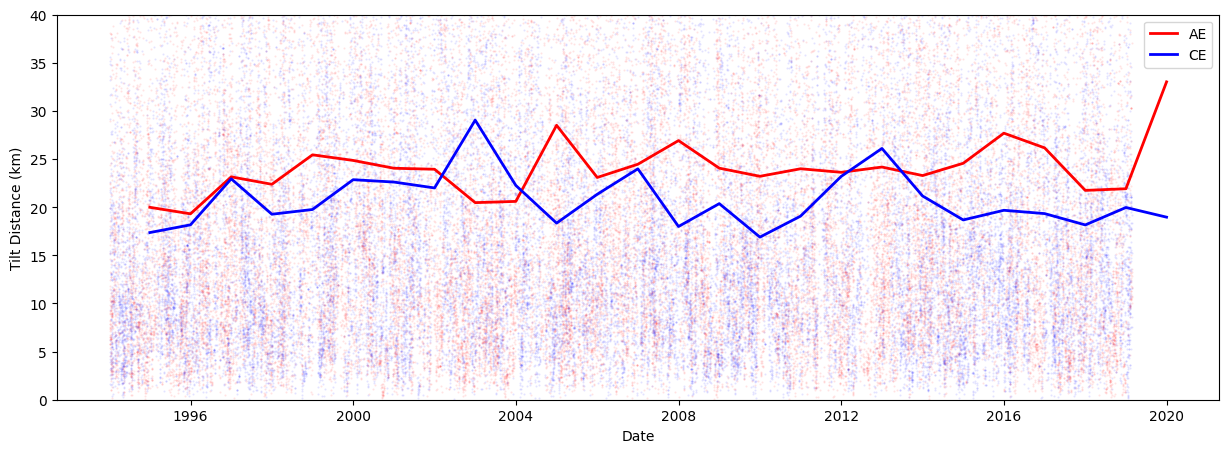

In [19]:
plt.figure(figsize=(15,5))

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    # mean = df.groupby(pd.Grouper(key='Date', freq='6MS')).TiltDis.mean()
    mean = df.groupby(pd.Grouper(key='Date', freq='1YE')).TiltDis.mean()
    plt.scatter(df.Date, df.TiltDis, s=1, alpha=0.1, color=c, marker='.')
    plt.plot(mean.index, mean.values, lw=2, color=c, label=label)

plt.xlabel('Date'); plt.legend()
plt.ylabel('Tilt Distance (km)')
plt.ylim(0, 40)
plt.show()


Could hypothesis that warmer waters = more stratified water = more tilt

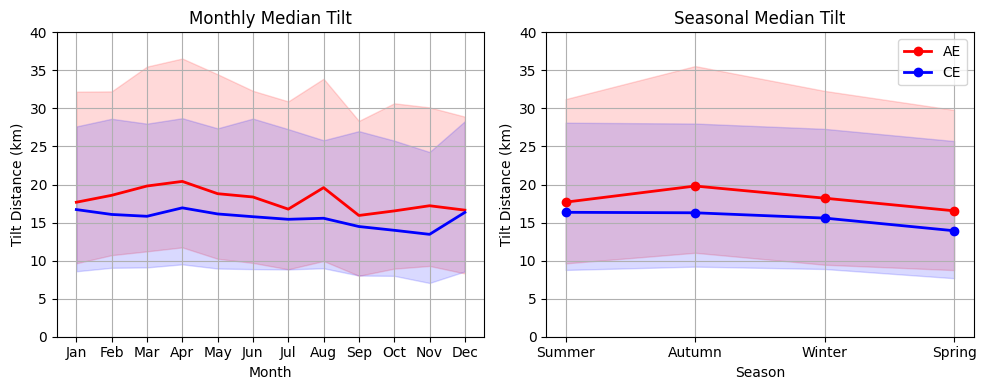

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Month'] = df_.Date.dt.month

    g = df_.groupby('Month').TiltDis
    med = g.median()
    q25 = g.quantile(0.25)
    q75 = g.quantile(0.75)

    ax.plot(med.index, med.values, lw=2, color=c, label=label)
    ax.fill_between(med.index, q25, q75, color=c, alpha=0.15)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Monthly Median Tilt')
ax.grid(True)

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    g = df_.groupby('Season', observed=True).TiltDis
    med = g.median().reindex(season_order)
    q25 = g.quantile(0.25).reindex(season_order)
    q75 = g.quantile(0.75).reindex(season_order)

    x = np.arange(len(season_order))
    ax.plot(x, med.values, lw=2, marker='o', color=c, label=label)
    ax.fill_between(x, q25, q75, color=c, alpha=0.15)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Seasonal Median Tilt')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


### Temperature

### Eddy Propogation

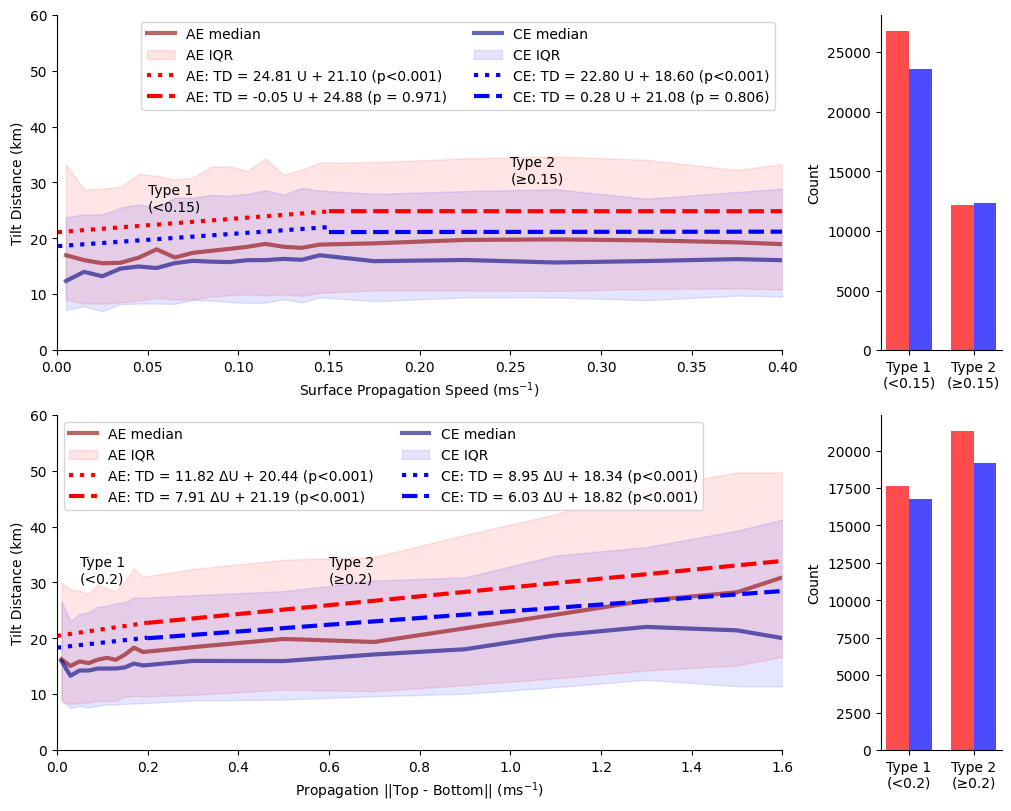

In [56]:
from scipy.stats import linregress

fig, ((ax1, ax1_hist), (ax2, ax2_hist)) = plt.subplots(
    2, 2, figsize=(10, 8),
    gridspec_kw={'width_ratios': [3, .5]},
    constrained_layout=True
)

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ======================================================================
# PANEL 1: Tilt vs EddyProp  +  PANEL 2: EddyProp class histogram
# ======================================================================

x_all1 = np.concatenate([
    df_AE['EddyProp'].dropna().values,
    df_CE['EddyProp'].dropna().values
])

split1 = 0.15
int1, int2 = 0.01, 0.05
bins1 = np.concatenate([
    np.arange(0, split1, int1),
    np.arange(split1, 0.4 + int2, int2)
])
bin_centers1 = 0.5 * (bins1[:-1] + bins1[1:])

EP_AE, EP_CE = [], []

for cyc, df_cyc in [('AE', df_AE), ('CE', df_CE)]:
    df = df_cyc[['EddyProp', 'TiltDis']].dropna().copy()

    xval = df['EddyProp'].values
    tilt = df['TiltDis'].values

    if cyc == 'AE':
        EP_AE.append(xval)
    else:
        EP_CE.append(xval)

    digitized = np.digitize(xval, bins1)

    median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins1))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins1))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins1))]

    median = np.array(median)
    q25    = np.array(q25)
    q75    = np.array(q75)
    mask   = np.isfinite(median)

    # ax1.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax1.plot(bin_centers1[mask], median[mask],
             lw=3, alpha=.6, color=styles[cyc]['line'],
             label=f'{cyc} median')

    ax1.fill_between(bin_centers1[mask], q25[mask], q75[mask],
                     alpha=0.10, color=styles[cyc]['fill'],
                     label=f'{cyc} IQR')

    mask_left  = xval < split1
    mask_right = xval >= split1

    if mask_left.sum() > 2:
        m1, c1, r1, p1, se1 = linregress(xval[mask_left], tilt[mask_left])
        x1 = np.linspace(xval[mask_left].min(), xval[mask_left].max(), 100)
        y1 = m1 * x1 + c1
        eq_str = f'TD = {m1:.2f} U + {c1:.2f}' if c1 >= 0 else f'TD = {m1:.2f} U - {abs(c1):.2f}'
        p_str  = 'p<0.001' if p1 < 0.001 else f'p = {p1:.3f}'
        ax1.plot(x1, y1, ':', lw=3, color=styles[cyc]['fill'],
                 label=f'{cyc}: {eq_str} ({p_str})')

    if mask_right.sum() > 2:
        m2, c2, r2, p2, se2 = linregress(xval[mask_right], tilt[mask_right])
        x2 = np.linspace(xval[mask_right].min(), xval[mask_right].max(), 100)
        y2 = m2 * x2 + c2
        eq_str = f'TD = {m2:.2f} U + {c2:.2f}' if c2 >= 0 else f'TD = {m2:.2f} U - {abs(c2):.2f}'
        p_str  = 'p<0.001' if p2 < 0.001 else f'p = {p2:.3f}'
        ax1.plot(x2, y2, '--', lw=3, color=styles[cyc]['fill'],
                 label=f'{cyc}: {eq_str} ({p_str})')
ax1.text(.05, 25, f'Type 1\n(<{split1:.2f})')
ax1.text(.25, 30, f'Type 2\n(≥{split1:.2f})')

ax1.set_xlim(0, 0.4)
ax1.set_ylim(0, 60)
ax1.set_xlabel(r'Surface Propagation Speed (ms$^{-1}$)')
ax1.set_ylabel('Tilt Distance (km)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper right', ncol=2)

EP_AE = np.concatenate(EP_AE) if EP_AE else np.array([])
EP_CE = np.concatenate(EP_CE) if EP_CE else np.array([])

type1_AE = np.sum(EP_AE <  split1)
type2_AE = np.sum(EP_AE >= split1)
type1_CE = np.sum(EP_CE <  split1)
type2_CE = np.sum(EP_CE >= split1)

x = np.arange(2)
w = 0.35

ax1_hist.bar(x - w/2, [type1_AE, type2_AE], width=w,
             color=styles['AE']['fill'], alpha=0.7, label='AE')
ax1_hist.bar(x + w/2, [type1_CE, type2_CE], width=w,
             color=styles['CE']['fill'], alpha=0.7, label='CE')

ax1_hist.set_xticks(x)
ax1_hist.set_xticklabels([f'Type 1\n(<{split1:.2f})',
                          f'Type 2\n(≥{split1:.2f})'])
ax1_hist.set_ylabel('Count')
ax1_hist.spines['top'].set_visible(False)
ax1_hist.spines['right'].set_visible(False)

# ======================================================================
# PANEL 3: Tilt vs top_btm_diff  +  PANEL 4: top_btm_diff class histogram
# ======================================================================

x_all2 = np.concatenate([
    df_AE['top_btm_diff'].dropna().values,
    df_CE['top_btm_diff'].dropna().values
])

split2 = 0.2
int1, int2 = 0.02, 0.2
bins2 = np.concatenate([
    np.arange(0, split2, int1),
    np.arange(split2, 1.8 + int2, int2)
])
bin_centers2 = 0.5 * (bins2[:-1] + bins2[1:])

TB_AE, TB_CE = [], []

for cyc, df_cyc in [('AE', df_AE), ('CE', df_CE)]:
    df = df_cyc[['top_btm_diff', 'TiltDis']].dropna().copy()

    xval = df['top_btm_diff'].values
    tilt = df['TiltDis'].values

    if cyc == 'AE':
        TB_AE.append(xval)
    else:
        TB_CE.append(xval)

    digitized = np.digitize(xval, bins2)

    median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins2))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins2))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins2))]

    median = np.array(median)
    q25    = np.array(q25)
    q75    = np.array(q75)
    mask   = np.isfinite(median)

    # ax2.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax2.plot(bin_centers2[mask], median[mask],
             lw=3, alpha=.6, color=styles[cyc]['line'],
             label=f'{cyc} median')

    ax2.fill_between(bin_centers2[mask], q25[mask], q75[mask],
                     alpha=0.10, color=styles[cyc]['fill'],
                     label=f'{cyc} IQR')

    mask_left  = xval < split2
    mask_right = xval >= split2

    if mask_left.sum() > 2:
        m1, c1, r1, p1, se1 = linregress(xval[mask_left], tilt[mask_left])
        x1 = np.linspace(xval[mask_left].min(), xval[mask_left].max(), 100)
        y1 = m1 * x1 + c1
        eq_str = f'TD = {m1:.2f} ΔU + {c1:.2f}' if c1 >= 0 else f'TD = {m1:.2f} ΔU - {abs(c1):.2f}'
        p_str  = 'p<0.001' if p1 < 0.001 else f'p = {p1:.3f}'
        ax2.plot(x1, y1, ':', lw=3, color=styles[cyc]['fill'],
                 label=f'{cyc}: {eq_str} ({p_str})')

    if mask_right.sum() > 2:
        m2, c2, r2, p2, se2 = linregress(xval[mask_right], tilt[mask_right])
        x2 = np.linspace(xval[mask_right].min(), xval[mask_right].max(), 100)
        y2 = m2 * x2 + c2
        eq_str = f'TD = {m2:.2f} ΔU + {c2:.2f}' if c2 >= 0 else f'TD = {m2:.2f} ΔU - {abs(c2):.2f}'
        p_str  = 'p<0.001' if p2 < 0.001 else f'p = {p2:.3f}'
        ax2.plot(x2, y2, '--', lw=3, color=styles[cyc]['fill'],
                 label=f'{cyc}: {eq_str} ({p_str})')
ax2.text(.05, 30, f'Type 1\n(<{split2:.1f})')
ax2.text(.6, 30, f'Type 2\n(≥{split2:.1f})')

ax2.set_xlim(0, 1.6)
ax2.set_ylim(0, 60)
ax2.set_xlabel(r'Propagation ||Top - Bottom|| (ms$^{-1}$)')
ax2.set_ylabel('Tilt Distance (km)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper left', ncol=2)

TB_AE = np.concatenate(TB_AE) if TB_AE else np.array([])
TB_CE = np.concatenate(TB_CE) if TB_CE else np.array([])

type1_AE = np.sum(TB_AE <  split2)
type2_AE = np.sum(TB_AE >= split2)
type1_CE = np.sum(TB_CE <  split2)
type2_CE = np.sum(TB_CE >= split2)

x = np.arange(2)
w = 0.35

ax2_hist.bar(x - w/2, [type1_AE, type2_AE], width=w,
             color=styles['AE']['fill'], alpha=0.7, label='AE')
ax2_hist.bar(x + w/2, [type1_CE, type2_CE], width=w,
             color=styles['CE']['fill'], alpha=0.7, label='CE')

ax2_hist.set_xticks(x)
ax2_hist.set_xticklabels([f'Type 1\n(<{split2:.1f})',
                          f'Type 2\n(≥{split2:.1f})'])
ax2_hist.set_ylabel('Count')
ax2_hist.spines['top'].set_visible(False)
ax2_hist.spines['right'].set_visible(False)

plt.show()



### Vorticity

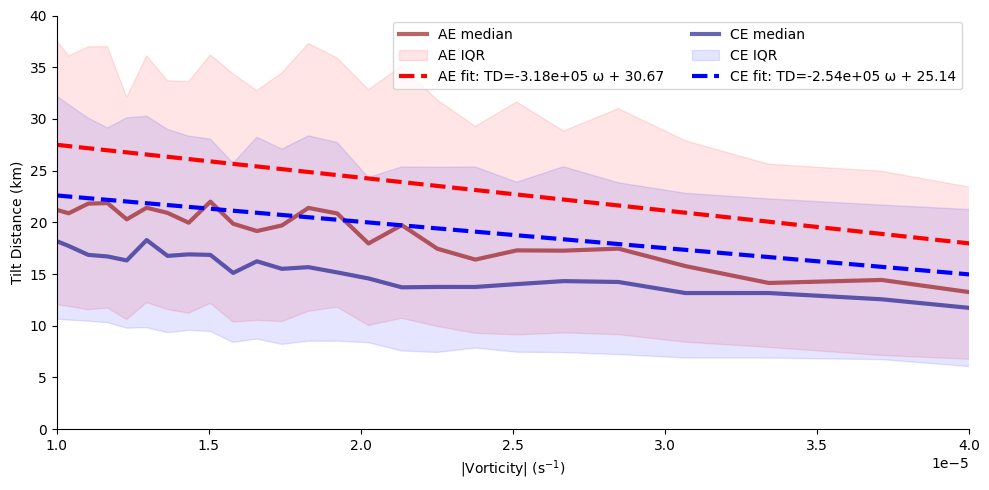

In [22]:
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins (frequency matched)
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all[df_all.w.abs() < 5e-5].dropna(subset=['w'])
w_all = df_all.w.abs().values
w_all = w_all[w_all > 0]

nbins = 30
bins = np.quantile(w_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bins = bins[bins> .75e-5]
bin_centers = 0.5 * (bins[:-1] + bins[1:])


# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked[df_masked.w.abs() < 5e-5].dropna(subset=['w', 'TiltDis'])

    vort = df_masked['w'].abs().values
    tilt = df_masked['TiltDis'].values

    digitized = np.digitize(vort, bins)

    median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(vort, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')

    # ------------------------------------------------------------
    # Linear regression on restricted interval 1e-5 ≤ ω ≤ 5e-5
    # ------------------------------------------------------------
    mask_reg = (vort >= 1e-5) & (vort <= 5e-5)

    if mask_reg.sum() > 2:
        xr = vort[mask_reg]
        yr = tilt[mask_reg]

        m, c, r, p, se = linregress(xr, yr)

        x_fit = np.linspace(1e-5, 5e-5, 200)
        y_fit = m * x_fit + c

        ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc} fit: TD={m:.2e} ω + {c:.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_xlim(1e-5, 4e-5)
ax.set_ylim(0, 40)
ax.set_xlabel(r'|Vorticity| (s$^{-1}$)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


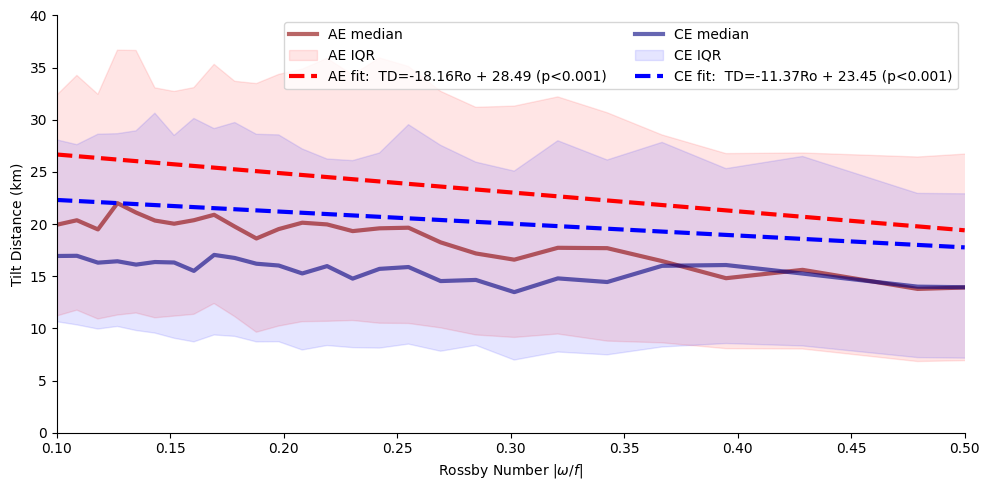

In [23]:
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins
# ------------------------------------------------------------
df_all = df_eddies.dropna(subset=['Ro'])
w_all = df_all.Ro.abs().values
w_all = w_all[w_all > 0]

nbins = 30
bins = np.quantile(w_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
# bins = bins[bins<1]
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].dropna(subset=['Ro','TiltDis'])

    vort = df_masked['Ro'].abs().values
    tilt = df_masked['TiltDis'].values

    digitized = np.digitize(vort, bins)

    median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # # scatter
    # ax.scatter(vort, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    # median + IQR
    ax.plot(bin_centers, median, alpha=.6,
            lw=3, color=styles[cyc]['line'],
            label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10,
                    label=f'{cyc} IQR')

    # ------------------------------------------------------------
    # Linear regression restricted to 0.1 <= Ro <= 0.5
    # ------------------------------------------------------------
    mask_reg = (vort >= 0.1) & (vort <= 0.5)

    if mask_reg.sum() > 2:
        xr = vort[mask_reg]
        yr = tilt[mask_reg]

        m, c, r, p, se = linregress(xr, yr)

        x_line = np.linspace(0.1, 0.5, 200)
        y_line = m * x_line + c
        p_str  = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'

        ax.plot(x_line, y_line, '--', lw=3,
                color=styles[cyc]['fill'],
                label=f'{cyc} fit:  TD={m:.2f}Ro + {c:.2f} ({p_str})')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_xlim(0.1, .5)
ax.set_ylim(0, 40)
ax.set_xlabel(r'Rossby Number $|\omega/f|$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()


### Deformation

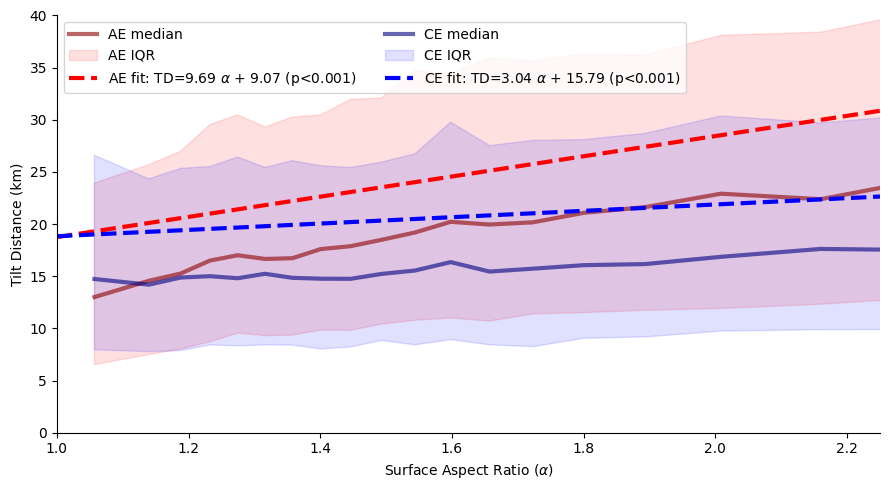

In [24]:
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(9, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

df_all = df_eddies.copy()
df_all = df_all[(df_all.AR < 3.5) & (df_all.AR > 0)].dropna(subset=['AR'])

w_all = df_all.AR.values

# quantile-based bins
nbins = 20
bins = np.quantile(w_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)

for cyc, df_cyc in [('AE', df_AE), ('CE', df_CE)]:

    dfp = df_cyc.copy()
    dfp = dfp[(dfp.AR < 3.5) & (dfp.AR > 0)].dropna(subset=['AR', 'TiltDis'])

    # --------- median / IQR ----------
    dfp['bin'] = pd.cut(dfp.AR, bins=bins, include_lowest=True)
    grouped = dfp.groupby('bin', observed=False).TiltDis

    median = grouped.median()
    q25    = grouped.quantile(0.25)
    q75    = grouped.quantile(0.75)

    bin_centers = np.array([0.5 * (b.left + b.right) for b in median.index])
    mask = median.notna()

    # ax.scatter(dfp.AR.values, dfp.TiltDis.values,
    #            s=1, alpha=0.1, marker='.', color=styles[cyc]['fill'])

    ax.plot(bin_centers[mask], median.values[mask], lw=3, alpha=.6,
            color=styles[cyc]['line'], label=f'{cyc} median')

    ax.fill_between(bin_centers[mask], q25.values[mask], q75.values[mask],
                    color=styles[cyc]['fill'], alpha=0.12, label=f'{cyc} IQR')

    # --------- linear regression in [1, 1.5] ----------
    ar = dfp.AR.values
    td = dfp.TiltDis.values

    mask_reg = (ar >= 1.0) & (ar <= 2.25)

    xr = np.asarray(ar[mask_reg], float).ravel()
    yr = np.asarray(td[mask_reg], float).ravel()

    # drop any NaNs just in case
    valid = np.isfinite(xr) & np.isfinite(yr)
    xr, yr = xr[valid], yr[valid]

    if xr.size > 1:
        m, c, r, p, se = linregress(xr, yr)
        x_fit = np.linspace(1.0, 2.25, 200)
        y_fit = m * x_fit + c
        p_str  = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'
        
        ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
                label=fr'{cyc} fit: TD={m:.2f} $\alpha$ + {c:.2f} ({p_str})')

ax.set_xlim(1, 2.25)
ax.set_ylim(0, 40)
ax.set_xlabel(r'Surface Aspect Ratio ($\alpha$)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)
plt.tight_layout()



### Bathymetry

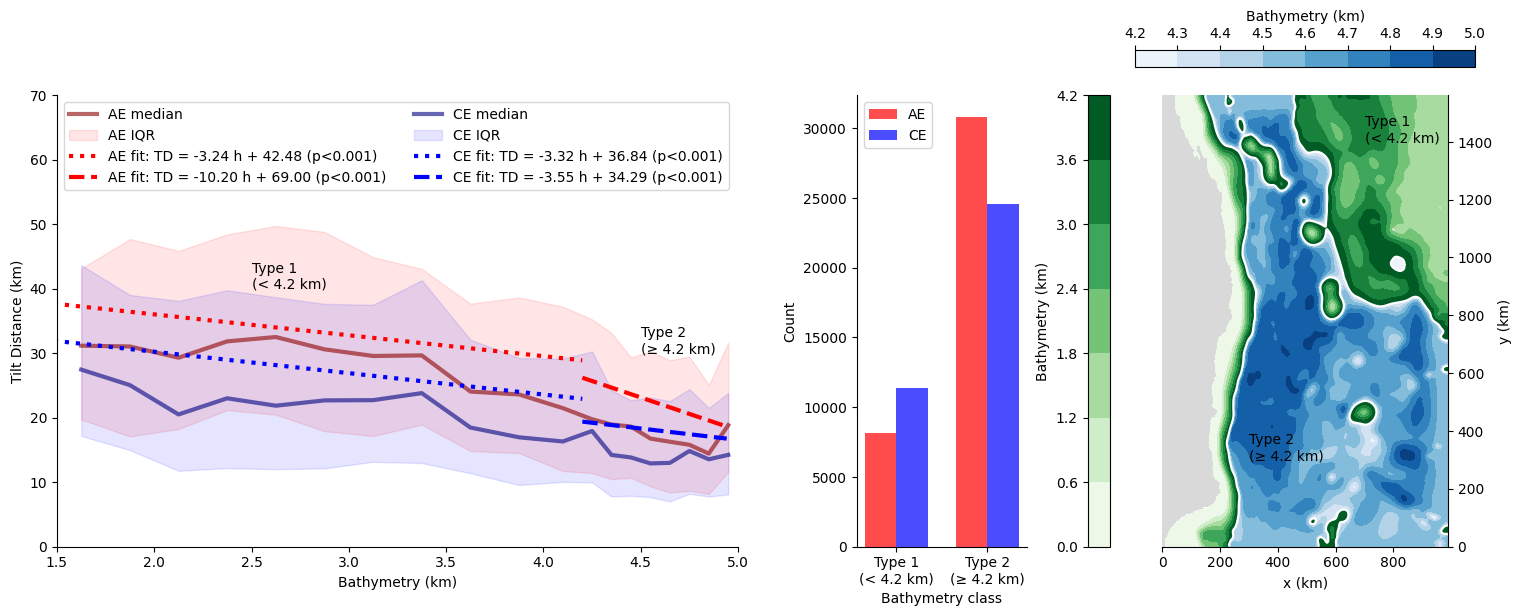

In [25]:
fig, (ax, ax_hist, ax2) = plt.subplots(
    1, 3, figsize=(15, 6),
    gridspec_kw={'width_ratios': [2, .5, 1]},
    constrained_layout=True
)

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy', 'fill': 'blue'}
}

split = 4.2
int1, int2 = 0.25, 0.1
bins = np.concatenate([
    np.arange(1.5, split, int1),
    np.arange(split, 5 + int2, int2)
])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

bathy_AE = []
bathy_CE = []

for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].dropna(subset=['h', 'TiltDis']).copy()

    bathy = df_masked['h'].values / 1e3
    tilt  = df_masked['TiltDis'].values

    if cyc == 'AE':
        bathy_AE.append(bathy)
    else:
        bathy_CE.append(bathy)

    digitized = np.digitize(bathy, bins)

    median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    ax.plot(bin_centers, median, color=styles[cyc]['line'], lw=3, alpha=.6, label=f'{cyc} median')
    ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=0.1, label=f'{cyc} IQR')

    mask_left = bathy < split
    if mask_left.sum() > 2:
        m1, c1, r1, p1, se1 = linregress(bathy[mask_left], tilt[mask_left])
        x1 = np.linspace(bathy[mask_left].min(), bathy[mask_left].max(), 100)
        y1 = m1 * x1 + c1
        eq_str = f'TD = {m1:.2f} h + {c1:.2f}' if c1 >= 0 else f'TD = {m1:.2f} h - {abs(c1):.2f}'
        p_str  = 'p<0.001' if p1 < 0.001 else f'p = {p1:.3f}'
        ax.plot(x1, y1, ':', lw=3, color=styles[cyc]['fill'], label=f'{cyc} fit: {eq_str} ({p_str})')

    mask_right = bathy >= split
    if mask_right.sum() > 2:
        m2, c2, r2, p2, se2 = linregress(bathy[mask_right], tilt[mask_right])
        x2 = np.linspace(bathy[mask_right].min(), bathy[mask_right].max(), 100)
        y2 = m2 * x2 + c2
        eq_str = f'TD = {m2:.2f} h + {c2:.2f}' if c2 >= 0 else f'TD = {m2:.2f} h - {abs(c2):.2f}'
        p_str  = 'p<0.001' if p2 < 0.001 else f'p = {p2:.3f}'
        ax.plot(x2, y2, '--', lw=3, color=styles[cyc]['fill'], label=f'{cyc} fit: {eq_str} ({p_str})')

bathy_AE = np.concatenate(bathy_AE) if bathy_AE else np.array([])
bathy_CE = np.concatenate(bathy_CE) if bathy_CE else np.array([])

ax.text(2.5, 40, f'Type 1\n(< {split} km)')
ax.text(4.5, 30, f'Type 2\n(≥ {split} km)')

# ------------------------------------------------------------------
# MIDDLE PANEL: TYPE 1 / TYPE 2 COUNTS (AE vs CE)
# Type 1: bathy < split
# Type 2: bathy >= split
# ------------------------------------------------------------------
type1_AE = np.sum(bathy_AE < split)
type2_AE = np.sum(bathy_AE >= split)
type1_CE = np.sum(bathy_CE < split)
type2_CE = np.sum(bathy_CE >= split)

x = np.arange(2)
width = 0.35

ax_hist.bar(x - width/2, [type1_AE, type2_AE],
            width=width, label='AE',
            alpha=0.7, color=styles['AE']['fill'])
ax_hist.bar(x + width/2, [type1_CE, type2_CE],
            width=width, label='CE',
            alpha=0.7, color=styles['CE']['fill'])

ax_hist.set_xticks(x)
ax_hist.set_xticklabels([f'Type 1\n(< {split} km)', f'Type 2\n(≥ {split} km)'])
ax_hist.set_ylabel('Count')
ax_hist.set_xlabel('Bathymetry class')
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.legend(loc='upper left')

# ------------------------------------------------------------------
# RIGHT PANEL: MAP (unchanged)
# ------------------------------------------------------------------
h_mask = np.where(mask_rho, h, np.nan)
cf = ax2.contourf(X_grid, Y_grid, np.where(h_mask/1e3 > split, np.nan, h_mask/1e3), cmap='Greens')#, vmax=split)
cbar = fig.colorbar(cf, ax=ax2, location='left')
cbar.set_label('Bathymetry (km)')
cf = ax2.contourf(X_grid, Y_grid, np.where(h_mask/1e3 < split, np.nan, h_mask/1e3), cmap='Blues')#, vmin=split)
cbar = fig.colorbar(cf, ax=ax2, location='top')
cbar.set_label('Bathymetry (km)')
ax2.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
ax2.contour(X_grid, Y_grid, h/1e3, levels=[split], colors=['w'])

ax2.text(700, 1400, f'Type 1\n(< {split} km)')
ax2.text(300, 300, f'Type 2\n(≥ {split} km)')

ax2.set_aspect('equal', adjustable='box')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# left panel cosmetics
ax.set_xlim(bins.min(), bins.max())
ax.set_ylim(0, 70)
ax.set_xlabel('Bathymetry (km)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)

plt.show()


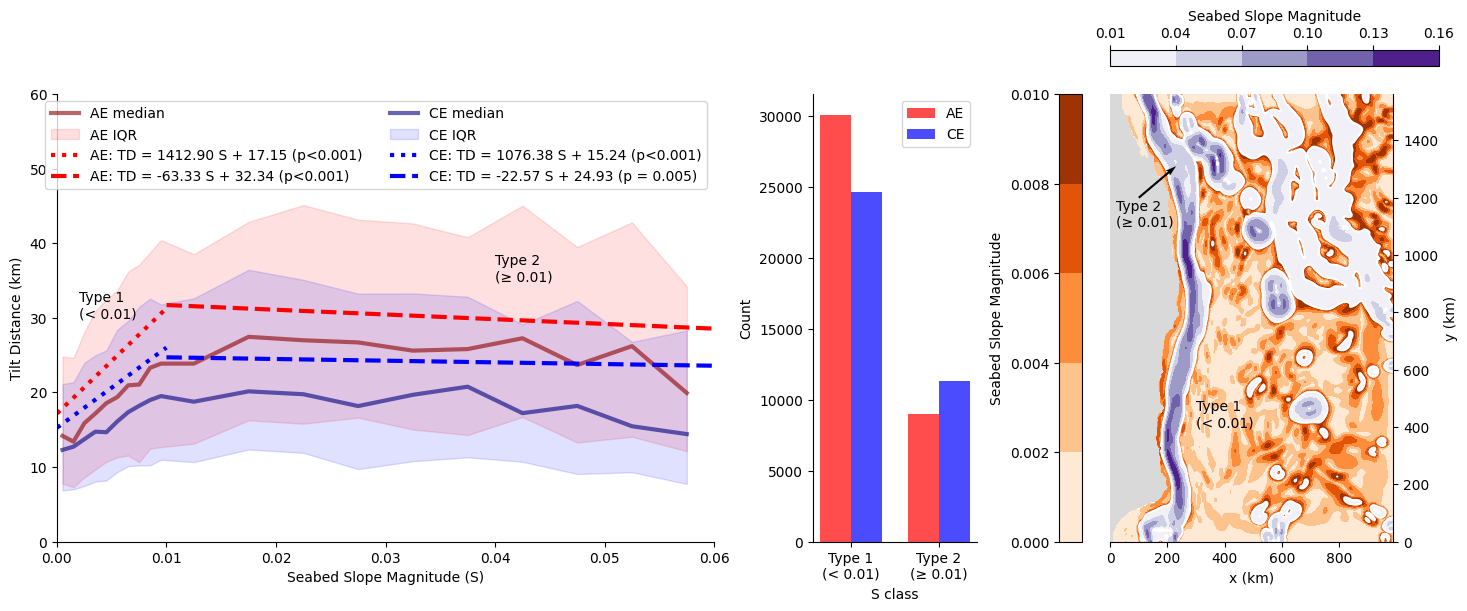

In [49]:
fig, (ax, ax_hist, ax2) = plt.subplots(
    1, 3, figsize=(15, 6),
    gridspec_kw={'width_ratios': [2, .5, 1]},
    constrained_layout=True
)

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy', 'fill': 'blue'}
}

df = df_eddies.copy()
w = df.s

split_s = 0.01

int1, int2 = 0.001, 0.005
bins = np.concatenate([
    np.arange(w.min(), split_s, int1),
    np.arange(split_s, .06 + int2, int2)
])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

slope_AE = []
slope_CE = []

for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['s', 'TiltDis'])

    slope_val = df_masked['s'].values
    tilt = df_masked['TiltDis'].values

    if cyc == 'AE':
        slope_AE.append(slope_val)
    else:
        slope_CE.append(slope_val)

    df_masked['bin'] = pd.cut(df_masked.s, bins=bins, include_lowest=True)
    grouped = df_masked.groupby('bin', observed=False).TiltDis

    median = grouped.median().values
    q25 = grouped.quantile(0.25).values
    q75 = grouped.quantile(0.75).values

    ax.plot(bin_centers, median, lw=3, alpha=.6,
            color=styles[cyc]['line'], label=f'{cyc} median')
    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.12,
                    label=f'{cyc} IQR')

    mask_left = slope_val < split_s
    if mask_left.sum() > 2:
        m1, c1, r1, p1, se1 = linregress(slope_val[mask_left], tilt[mask_left])
        x1 = np.linspace(slope_val[mask_left].min(), slope_val[mask_left].max(), 200)
        y1 = m1 * x1 + c1
        eq_str = f'TD = {m1:.2f} S + {c1:.2f}' if c1 >= 0 else f'TD = {m1:.2f} S - {abs(c1):.2f}'
        p_str  = 'p<0.001' if p1 < 0.001 else f'p = {p1:.3f}'
        ax.plot(x1, y1, ':', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc}: {eq_str} ({p_str})')

    mask_right = slope_val >= split_s
    if mask_right.sum() > 2:
        m2, c2, r2, p2, se2 = linregress(slope_val[mask_right], tilt[mask_right])
        x2 = np.linspace(slope_val[mask_right].min(), slope_val[mask_right].max(), 200)
        y2 = m2 * x2 + c2
        eq_str = f'TD = {m2:.2f} S + {c2:.2f}' if c2 >= 0 else f'TD = {m2:.2f} S - {abs(c2):.2f}'
        p_str  = 'p<0.001' if p2 < 0.001 else f'p = {p2:.3f}'
        ax.plot(x2, y2, '--', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc}: {eq_str} ({p_str})')

slope_AE = np.concatenate(slope_AE) if slope_AE else np.array([])
slope_CE = np.concatenate(slope_CE) if slope_CE else np.array([])

ax.text(0.002, 30, f'Type 1\n(< {split_s})')
ax.text(.04, 35, f'Type 2\n(≥ {split_s})')

ax.set_xlim(0, .06)
ax.set_ylim(0, 60)
ax.set_xlabel('Seabed Slope Magnitude (S)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

ax2.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
s_mask = np.where(mask_rho, s, np.nan)
cf = ax2.contourf(X_grid, Y_grid, np.where(s_mask < split_s, np.nan, s_mask), cmap='Purples', levels=np.linspace(0.01, .16, 6))
cbar = fig.colorbar(cf, ax=ax2, location='top')
cbar.set_label('Seabed Slope Magnitude')
cf = ax2.contourf(X_grid, Y_grid, np.where(s_mask > split_s, np.nan, s_mask), cmap='Oranges', levels=np.linspace(0, .01, 6))
cbar = fig.colorbar(cf, ax=ax2, location='left')
cbar.set_label('Seabed Slope Magnitude')
ax2.contour(X_grid, Y_grid, s, levels=[split_s], colors=['w'])

ax2.text(300, 400, f'Type 1\n(< {split_s})')
ax2.text(20, 1100, f'Type 2\n(≥ {split_s})')
x0, y0 = 100, 1200
x1, y1 = 230, 1310
ax2.quiver(x0, y0, x1 - x0, y1 - y0, angles='xy', scale_units='xy', scale=1, zorder=5)

ax2.set_aspect('equal', adjustable='box')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# -----------------------------
# middle panel: Type 1 / Type 2 bar plot (AE / CE)
# Type 1: S < split_s
# Type 2: S >= split_s
# -----------------------------
type1_AE = np.sum(slope_AE < split_s)
type2_AE = np.sum(slope_AE >= split_s)
type1_CE = np.sum(slope_CE < split_s)
type2_CE = np.sum(slope_CE >= split_s)

x = np.arange(2)
width = 0.35

ax_hist.bar(x - width/2, [type1_AE, type2_AE],
            width=width, label='AE',
            alpha=0.7, color=styles['AE']['fill'])
ax_hist.bar(x + width/2, [type1_CE, type2_CE],
            width=width, label='CE',
            alpha=0.7, color=styles['CE']['fill'])

ax_hist.set_xticks(x)
ax_hist.set_xticklabels([f'Type 1\n(< {split_s})', f'Type 2\n(≥ {split_s})'])
ax_hist.set_ylabel('Count')
ax_hist.set_xlabel('S class')
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.legend(loc='upper right')

plt.show()


In [ ]:
break


### Tilt Direction

In [ ]:
# Replace these with your actual data arrays
directions = df_eddies.TiltDir
magnitudes = df_eddies.TiltDis

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))
plt.show()


In [ ]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()

In [ ]:
ae = df_AE_
north = ae[(ae.TiltDir < 90) | (ae.TiltDir > 270)]
north_east = ae[ae.TiltDir < 90]

print('% of AEs tilted northward:')
print(len(north) / len(ae))

print('% of AEs tilted northward with easterly component:')
print(len(north_east) / len(north))

print('% of TD between 0–40 km for northward tilts:')
print((north.TiltDis <= 40).mean())

ce = df_CE_
south = ce[(ce.TiltDir > 90) & (ce.TiltDir < 270)]
south_east = ce[(ce.TiltDir > 90) & (ce.TiltDir < 180)]

print('% of CEs tilted southward:')
print(len(south) / len(ce))

print('% of CEs tilted southward with easterly component:')
print(len(south_east) / len(south))

print('% of TD between 0–40 km for southward tilts:')
print((south.TiltDis <= 40).mean())


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Tilt Distance ---
axs[0].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDis.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDis.dropna(), bins=100)
axs[0].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[0].set_ylim(-2200, 2200)
axs[0].axhline(0, color='k', linewidth=1)
axs[0].set_xlabel('Tilt Distance (km)')
axs[0].set_ylabel('Number of Eddy-Days')
yticks = axs[0].get_yticks()
axs[0].set_yticks(yticks)
axs[0].set_yticklabels([abs(int(t)) for t in yticks])

# --- Tilt Direction ---
axs[1].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDir.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDir.dropna(), bins=100)
axs[1].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[1].set_ylim(-1000, 1000)
axs[1].axhline(0, color='k', linewidth=1)
axs[1].set_xlabel('Tilt Direction (° True North)')
axs[1].set_ylabel('Number of Eddy-Days')
yticks = axs[1].get_yticks()
axs[1].set_yticks(yticks)
axs[1].set_yticklabels([abs(int(t)) for t in yticks])

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 20, 40, 60, 80, np.inf]
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray(sub.TiltDir.dropna().values, float)
            m = np.asarray(sub.TiltDis.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 1.8]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()


### Where is tilt not being measured?

In [ ]:
df_nt = df_eddies[np.isnan(df_eddies.TiltDis)].copy()
df_nt = df_nt[(np.abs(df_nt.Day_idx-(df_nt.Age-1)) > 2) & (df_nt.Day_idx > 2)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

cmaps = ['Greens', 'Reds', 'Blues']
labels = ['Eddy-Day Count', 'AE-Day Count', 'CE-Day Count']
# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_nt, df_nt[df_nt.Cyc == 'AE'], df_nt[df_nt.Cyc == 'CE']]):
    eddy_x = subset.xc
    eddy_y = subset.yc
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d].pcolormesh(x_edges, y_edges, H, cmap=cmaps[d])
    fig.colorbar(pcm, ax=axs[d], label=labels[d])
    
    axs[d].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    axs[d].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = axs[d].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    axs[d].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    axs[d].set_xlabel('x (km)')
    axs[d].set_ylabel('y (km)')
    axs[d].set_aspect('equal')

    axs[d].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

def cell_counts_valid_invalid(df):
    out, vmax = {}, 0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            v = np.count_nonzero(~sub.TiltDis.isna())
            sub_excluding_beg_end = sub[(np.abs(sub.Day_idx-(sub.Age-1)) > 2) & (sub.Day_idx > 2)]
            iv = np.count_nonzero(sub_excluding_beg_end.TiltDis.isna())
            c = np.array([v, iv], dtype=int)
            out[(i,j)] = c
            vmax = max(vmax, v)  # <— track max valid only
    return out, (1 if vmax == 0 else vmax)

def make_autopct(vals):
    total = np.sum(vals)
    def _inner(pct):
        v = int(round(pct*total/100.0))
        return f"{v}" if v > 0 else ""
    return _inner

def add_pie_valid_invalid(ax, x0, y0, counts, tmax, frac=0.25, tick_flag=False, title='', color=plt.cm.Greens(0.6)):
    if counts is None or counts.sum() == 0: return
    s_base = frac * min(cell_w, cell_h)
    scale = 0.35 + 0.65 * (counts[0] / tmax)  # <— use valid only
    s = s_base * scale
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData)
    iax.pie(counts, startangle=90, counterclock=False,
            colors=[color, plt.cm.Greys(0.55)],
            wedgeprops={'edgecolor':'k','linewidth':0.3},
            autopct=make_autopct(counts), pctdistance=0.65,
            textprops={'fontsize':12, 'fontweight': 'bold'})
    iax.set_aspect('equal'); iax.set_xticks([]); iax.set_yticks([])
    for spine in iax.spines.values(): spine.set_visible(False)
    if tick_flag:
        ax.legend(handles=[
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color,
                       markeredgecolor='k', markersize=10, label='Valid Tilt'),
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=plt.cm.Greys(0.55),
                       markeredgecolor='k', markersize=10, label='Invalid Tilt')],
            loc='upper right', frameon=False, fontsize=12, bbox_to_anchor=(1.35, .9),
            title=title, title_fontsize=12)

fracs = [1.2, 1.2, 1.2]
fig, axs = plt.subplots(1, 3, figsize=(20, 9), sharey=True)
colors = [plt.cm.Greens(0.6), plt.cm.Reds(0.6), plt.cm.Blues(0.6)]
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    counts_map, tmax = cell_counts_valid_invalid(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            tick_flag = (i == 2 and j == 3)
            add_pie_valid_invalid(ax, xc, yc, counts_map[(i,j)], tmax, frac=fracs[p],
                                  tick_flag=tick_flag, color=colors[p], title=f'{titles[p]}:')
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

for ax in axs: ax.set_xlabel('x (km)', fontsize=11)
axs[0].set_ylabel('y (km)', fontsize=11)
plt.tight_layout(); plt.show()


In [ ]:
len(df_eddies)

In [ ]:
df_valid = df_eddies[(np.abs(df_eddies.Day_idx-(df_eddies.Age-1)) > 2) & (df_eddies.Day_idx > 2)].copy()
len(df_valid[~df_valid.TiltDis.isna()])/ len(df_valid)

In [ ]:
len(df_valid[~df_valid.TiltDis.isna()])

In [ ]:
len(df_valid)
